# Data Cleaning

Preprocessing the data - starting with the raw data from the Sentiment140 dataset, unaltered.
Remove unwanted characters/tokens, filter uninformative data entries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import html

from IPython.display import Markdown as md
from tqdm import tqdm

# DistilBert Tokenizer
from transformers import DistilBertTokenizer

c:\Users\thel0\OneDrive\Desktop\Sent Analysis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("classic")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 640x480 with 0 Axes>

In [3]:
# Optional (depends on monitor)
pd.set_option('max_colwidth', 800)

# tqdm progress bar for pandas methods
tqdm.pandas()

In [4]:
# Reading in data
df = pd.read_csv('data_unchanged.csv', names=['label', 'n1', 'n2', 'n3', 'n4', 'data'],
                   usecols=['label', 'data'],
                   encoding='latin-1')

### First Look at Data:

In [5]:
df.shape

(1600000, 2)

In [6]:
df.head()

,label,data
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [7]:
df['label'].value_counts()

label
0    800000
4    800000
Name: count, dtype: int64

As we can see by value counts, of the 1.6 million tweets in the dataset, half are positive - i.e. score of 4, and half are negative - score = 0.

### Rule-Based Preprocessing

Using several libraries (mainly regex, along with html and string) to filter various unwanted quirks of the data.
E.g. Remaining bits of html, non-english characters, redundant whitespace, letter spamming, URLs, Twitter handles, text encoding funk (non ascii/utf8 characters that show up in hex)

In [8]:
# Changing the score from a 0-4 scale to a 0-1 scale
df['sent'] = df.label.mod(3)

In [9]:
# Dropping the deprecated 0-4 scale column
df.drop('label', inplace=True, axis=1)

Defining functions for removing wonky twitter/html/encoding stuff - preprocessing and whatnot.
Regexing out special characters, non ascii, duplicate whitespace, etc.

In [10]:
# Remove punctuation, links, usernames and text encoding funkiness caused by the weirdness of the encoding situation with the dataset

def remove_weirdness(text):
    # Un-escaping html funk
    text = html.unescape(text)
    # Regexing newlines, urls, mentions etc.
    text = text.replace('\r', '').replace('\n', ' ').lower() 
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    # Remove non ascii/utf8
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    # Removing other funky stuff
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    # Removing instances of repeating characters 3+ e.g. hiiiiiii -> hii.  Alot of tweets with excessive rep. char.
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
    return text

# Clean hashtag character in body of tweet, hashtags after the tweet get removed wholesale
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #rem. post-tweet hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove the "#" symbol when within the tweet
    return new_tweet2

# Filter words containing $ or &
def filtering(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

# Whitespace pruning
def rm_whitespace(text):
    return re.sub("\s\s+" , " ", text)

# Final helper function, combining all of the above
def full_clean(text):
    return rm_whitespace(filtering(clean_hashtags(remove_weirdness(text))))

Applying the cleaning function defined above to the raw tweet data, and saving it to the tweet column

In [11]:
# Apply the full_clean function (which in turn calls all of the various preprocessing steps defined above)
df['text'] = df['data'].progress_apply(full_clean)

  1%|          | 9041/1600000 [00:00<00:34, 45646.31it/s]

100%|██████████| 1600000/1600000 [00:31<00:00, 50565.69it/s]


In [12]:
# Dropping pre-cleaning tweets
df.drop('data', inplace=True, axis=1)

In [13]:
df.head()

,sent,text
0,0,aww thats a bummer you shoulda got david carr of third day to do it d
1,0,is upset that he cant update his facebook by texting it and might cry as a result school today also blah
2,0,i dived many times for the ball managed to save 50 the rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i here because i cant see you all over there


Filtering tweets with a wordcount under a certain threshold (<=2)

In [14]:
# Helper function to count words (substrings seperated by white space)
def word_counter(text):
    tweet_len = len(text.split())
    return tweet_len

In [15]:
# Applying the word_counter function to the tweets in the dataframe, to create the new data_len column
df['data_len'] = df['text'].progress_apply(word_counter)

  0%|          | 0/1600000 [00:00<?, ?it/s]

100%|██████████| 1600000/1600000 [00:02<00:00, 710059.17it/s]


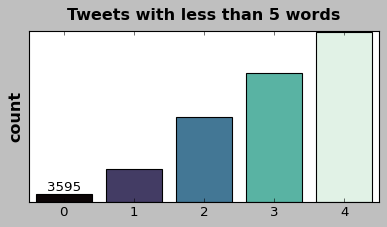

As we can see in the above graph, there were 3595 instances of zero-length tweets, post cleaning

In [16]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='data_len', data = df[df['data_len']<5], hue = 'data_len', palette = 'mako', legend = False)
plt.title('Tweets with less than 5 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

zero_list =df[df['data_len'] == 0]
zero_list = len(zero_list['data_len'])
md("As we can see in the above graph, there were %i instances of zero-length tweets, post cleaning"%(zero_list))

In [17]:
print(f" df Shape: {df.shape}")

 df Shape: (1600000, 3)


Filtering out the examples that have len <= 2 after cleaning:

In [18]:
df = df[df['data_len'] > 2]

# Printing the shape of dataframe after filtering to check how many entries were dropped
print(f" df Shape: {df.shape}")

 df Shape: (1541362, 3)


### DistilBert tokenizer

Using the distilbert tokenizer to filter sentences with unusually high token counts relative to maximum tweet length (typical of tweets containing gibberish or repeated strings)

In [19]:
#initialize the distilbert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [20]:
#recieves string as input and returns the token count as encoded by the distilbert tokenizer
def dbert_token_counts(text):
    tokens = tokenizer.encode(text, max_length=512, truncation=True)
    return len(tokens)

In [21]:
#creating a token_lens column in the data frame by applying the dbert_token_counts function to the tweet column
df['token_lens'] = df['text'].progress_apply(dbert_token_counts)

100%|██████████| 1541362/1541362 [06:57<00:00, 3688.43it/s]


In [22]:
#sort by highest token counts
df = df.sort_values(by='token_lens', ascending=False)

In [23]:
df.head()

,sent,text,data_len,token_lens
270191,0,hi7dp3ar3of2mm2or 2ar3ac3 m hi7of3rr9of3vd1bi9 mm1 hi7of3rr9of3vd1jr1pg2 mm2 hi7of3rr9of3vd1fc2 hr 9hi7rn 1vd1kb 9,12,73
1466515,1,80th tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet tweet,22,67
1517866,1,ohhushfornewmoon ohhushfornewmoon ohhushfornewmoon ohhushfornewmoon ohhushfornewmoon ohhushfornewmoon ohhushfornewmoon,7,58
1389742,1,oh whyd you need cheering titstitstitstitstitstitstitstitstitstitstitstitstitstitstitstitstitstitstitstitstitstitstitstitstits,6,57
148200,0,thats what ill end up doing no lie ughghghghiehihwehgweiohrow3i74892qf7897389472bcv85v7837v723897cv288,9,56


In [24]:
# Pruning the top 1000 tweets with abnormally high token counts
df = df.iloc[1000:]
df.head()

,sent,text,data_len,token_lens
253045,0,my sis got in the mail the complete series of charmed we hav not watchd it in yrs so sad i rememba wen pru died cant wait to wach it,30,41
397777,0,totally stressed out rite nw college wrk mounting up wish i cud hav hd time to gt it dne ystrday and hand it in wayy 2 mch 2 do d,30,41
369996,0,at skool this 1 guy askd me 2 b his gf i said no in the most kindest way i can think of it was nervewracking i stil feel bad urg,31,41
447810,0,went to fridays had a gop nd a ultamite margarita all n 30 mins boss too off to see the laker game had to go back to wkr im so buzzn,31,41
1470695,1,omg cant wait to hear all about it when we drive up 2gether cant wait 2 see vids lol be safe drivin home k ttys hugz nessa,27,41


In [25]:
df.to_csv('data_clean.csv', index=False, sep='\t')